# 香溪河水温数据建模
郭欣晟 2016010334 


## 研究背景介绍
   香溪河位于湖北省境内全长97.3公里，于香溪河镇东侧汇入长江。研究水温的变化规律对于研究香溪河流域水汽蒸发，研究气温、降雨等变量与水文的互动关系有相当重要的意义。
## 数据集介绍
数据来源于香溪河流域内的兴山水文站，数据集记录了自2003年起至2015年末的逐日水温与流量数据。本研究涉及范围为水文数据。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa 
import warnings
import itertools
from statsmodels.stats.stattools import durbin_watson as dw
from statsmodels.tsa.arima.model import ARIMA

## 数据清洗
   读取Excel文件中的数据，并对删除非闰年2月29日的缺失数据和重复数据

In [6]:
data = pd.read_excel('Dataset/Xiangxi_River.xlsx', sheet_name=1)
data_cleared = data.drop(['Unnamed: 0', '2012（2）'],axis=1)
data_tms_list = []

for column in data_cleared.columns:
    data_tms_list.append(data_cleared[column].values)
data_tms = np.array(data_tms_list)
data_tms_1D=data_tms[data_tms!='-'].astype(float)

# 数据探索
初步绘制数据图像，发现有一个明显的离群值。

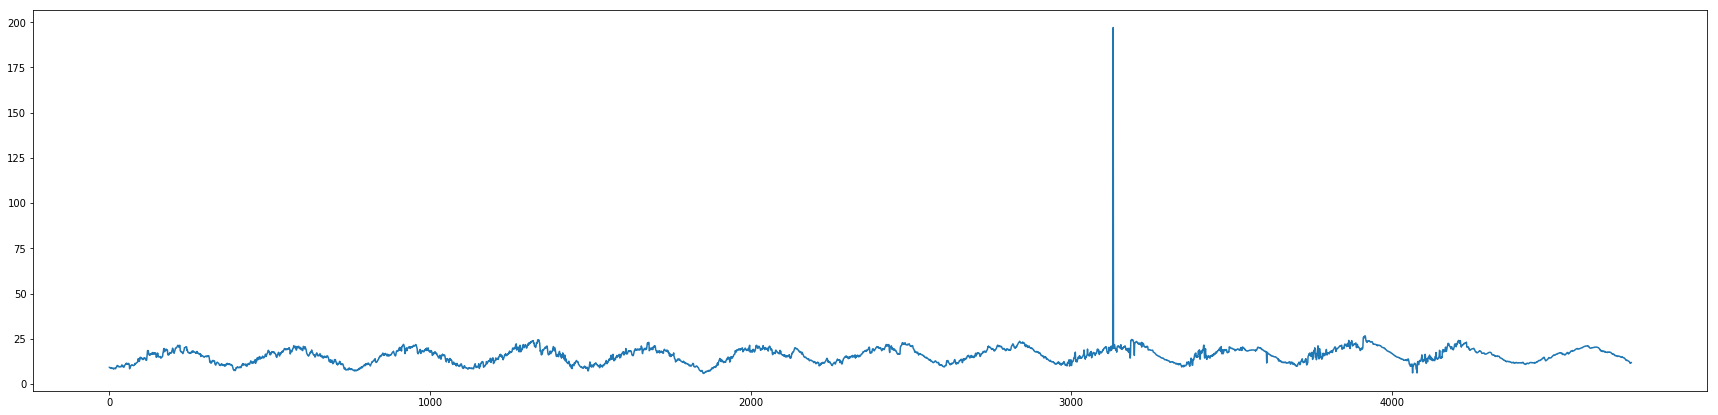

In [7]:
warnings.filterwarnings("ignore")
fig1 = plt.figure(figsize=(30,7))
plt.plot(data_tms_1D)
fig1.show()

检测离群值，发现应该是数据记录错误，对数据进行修正，并再次绘图。

In [8]:
data_tms_1D[data_tms_1D>100]

array([197.])

In [6]:
data_tms_1D[data_tms_1D>100] = 19.7

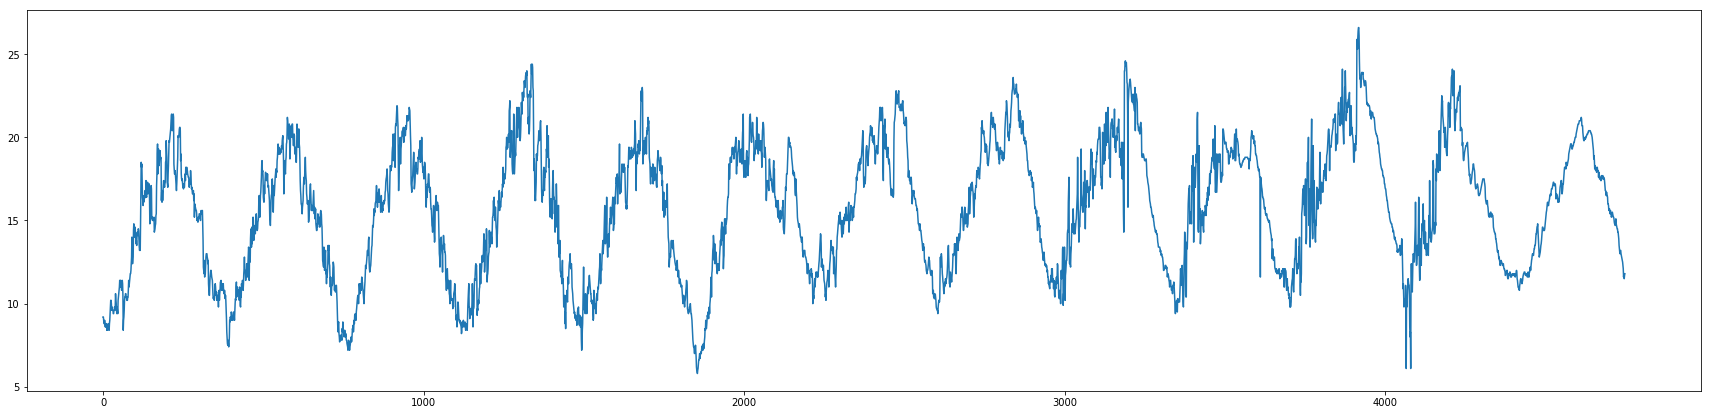

In [7]:
fig2 = plt.figure(figsize=(30,7))
plt.plot(data_tms_1D)
fig2.show()

通过上图可以发现水温数据的变化呈明显的周期态势，周期大致为365天。接下来对数据进行降采样，每7日进行平均，绘制图像，发现周期大致为52周。

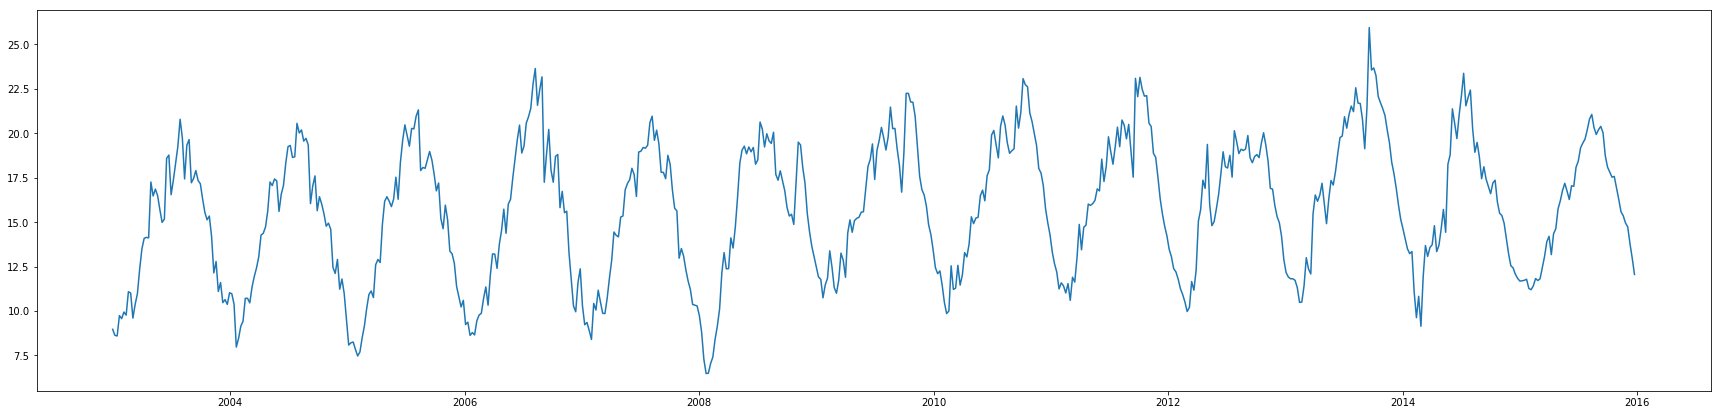

In [16]:
warnings.filterwarnings("ignore")
index = pd.date_range('20030101','20151231',freq='D')
tms = pd.Series(data_tms_1D, index = index)
data_week = tms.resample(rule='7D').sum()[:-1]/7
fig3 = plt.figure(figsize=(30,7))
plt.plot(data_week)
fig3.show()

对图像进行差分，并进行单位根检验，根据检验结果此时的数据已经平稳，但是依然可以发现差分数据存在明显的周期性。

(-8.279132897806852,
 4.569956607019315e-13,
 20,
 656,
 {'1%': -3.440357733229128,
  '5%': -2.8659559257802867,
  '10%': -2.569121649408834},
 1959.2252584452983)

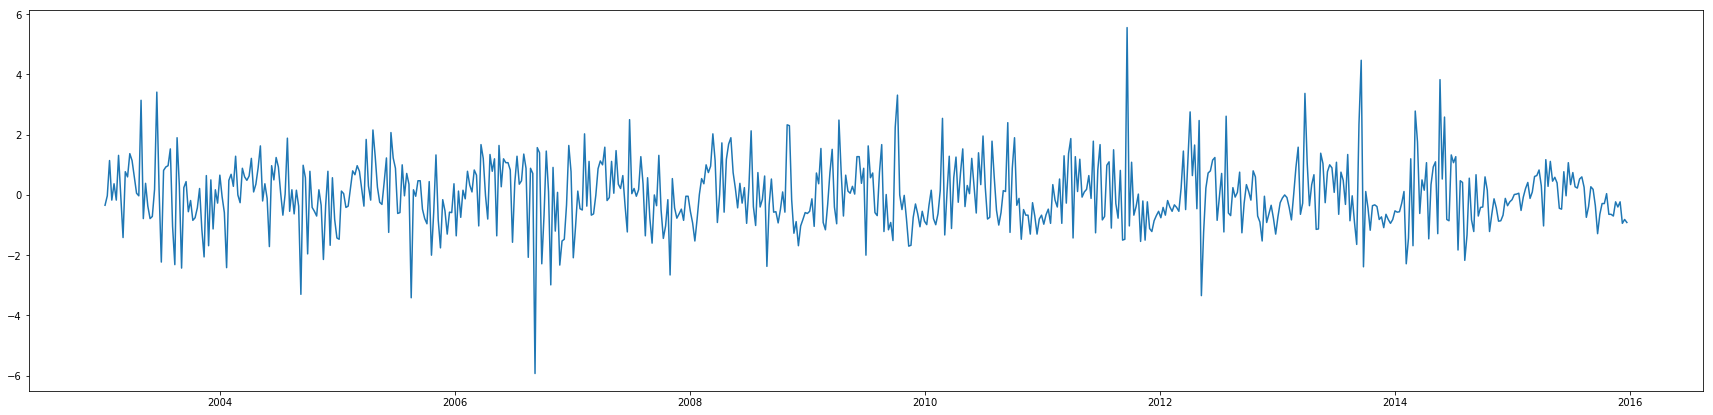

In [9]:
data_week_diff1 = data_week.diff()[1:]
fig3 = plt.figure(figsize=(30,7))
plt.plot(data_week_diff1)
fig3.show()
tsa.adfuller(data_week_diff1)

对数据进行周期差分，此时依然满足平稳性，周期性也明显消失。

(-14.508245670988465,
 5.781324584493621e-27,
 5,
 619,
 {'1%': -3.440958441424668,
  '5%': -2.86622052433566,
  '10%': -2.569262629991048},
 2119.888887054598)

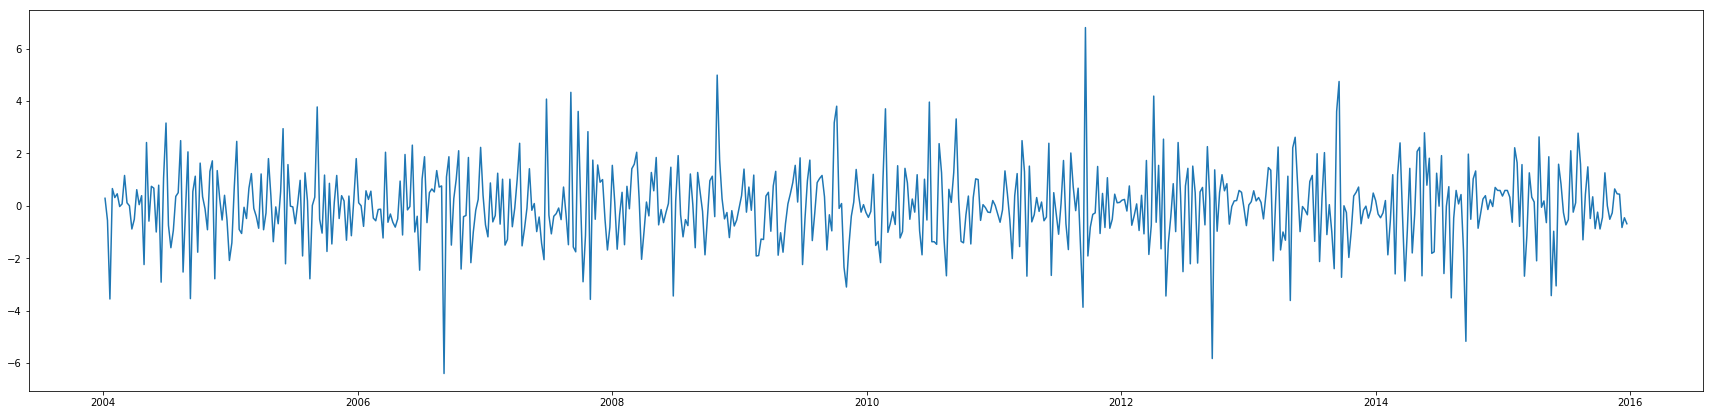

In [10]:
data_week_diffs = data_week_diff1.diff(52)[52:]
fig3 = plt.figure(figsize=(30,7))
plt.plot(data_week_diffs)
fig3.show()
tsa.adfuller(data_week_diffs)

对数据中的训练集与测试集进行划分，前499周为训练集，500周及500周之后为测试集。

In [11]:
data_train = data_week[:500]
data_test = data_week[500:]

# 模型建立
根据上述分析，此时间序列拥有明显的周期性，所以使用$\rm{SARIMA} (p,d,q)\times(P,D,Q)_s$模型，同时我们已经可以确定以下参数：
* $d=1$
* $D=1$
* $s=52$ 

接下来需要对其余的参数进行网格搜索，输出结果如下：

In [15]:
p = q = range(0, 3)
d = [1]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
 
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in pdq]
 
warnings.filterwarnings("ignore") # specify to ignore warning messages
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = ARIMA(data_train,order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52)52 - AIC:1597.6650352044935
ARIMA(0, 1, 0)x(0, 1, 1, 52)52 - AIC:1253.0551691807061
ARIMA(0, 1, 0)x(0, 1, 2, 52)52 - AIC:1097.7085571059886
ARIMA(0, 1, 0)x(1, 1, 0, 52)52 - AIC:1315.3844702458716
ARIMA(0, 1, 0)x(1, 1, 1, 52)52 - AIC:1262.4179760287957
ARIMA(0, 1, 0)x(1, 1, 2, 52)52 - AIC:1091.2604184139304
ARIMA(0, 1, 0)x(2, 1, 0, 52)52 - AIC:1123.7045548472752
ARIMA(0, 1, 0)x(2, 1, 1, 52)52 - AIC:1109.845411229833
ARIMA(0, 1, 0)x(2, 1, 2, 52)52 - AIC:1100.6537698513444
ARIMA(0, 1, 1)x(0, 1, 0, 52)52 - AIC:1570.7135838438135
ARIMA(0, 1, 1)x(0, 1, 1, 52)52 - AIC:1236.2775452410472
ARIMA(0, 1, 1)x(0, 1, 2, 52)52 - AIC:1084.6642766063387
ARIMA(0, 1, 1)x(1, 1, 0, 52)52 - AIC:1300.7845708054756
ARIMA(0, 1, 1)x(1, 1, 1, 52)52 - AIC:1245.326714688882
ARIMA(0, 1, 1)x(1, 1, 2, 52)52 - AIC:1079.1523685744332
ARIMA(0, 1, 1)x(2, 1, 0, 52)52 - AIC:1108.4060397136548
ARIMA(0, 1, 1)x(2, 1, 1, 52)52 - AIC:1097.9106763630375
ARIMA(0, 1, 1)x(2, 1, 2, 52)52 - AIC:1088.35307590

根据上述结果，选择$\rm{SARIMA} (1,1,1)\times(1,1,2)_{52}$，此时的$\rm AIC = 1071.4$。
# 模型部署

In [26]:
mod = ARIMA(data_train, order=(1, 1, 1), seasonal_order=(1, 1, 2, 52), enforce_stationarity=False, enforce_invertibility=False)

results = mod.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5622,0.125,4.481,0.000,0.316,0.808
ma.L1,-0.7758,0.109,-7.132,0.000,-0.989,-0.563
ar.S.L52,-0.5882,0.096,-6.105,0.000,-0.777,-0.399
ma.S.L52,-0.1679,0.127,-1.325,0.185,-0.416,0.080
ma.S.L104,-0.4357,0.107,-4.058,0.000,-0.646,-0.225
sigma2,1.2485,0.072,17.298,0.000,1.107,1.390


# 模型诊断
* 在右上的残差密度分布图中，我们看到红色KDE线与N(0,1)基本吻合，说明残差正常分布。

* 左下角的qq图显示，残差的有序分布遵循采用N(0, 1)的标准正态分布采样的线性趋势。

* 随着时间的推移（左上图）的残差不会显示任何明显的季节性，似乎是白噪声。这通过右下角的自相关（即相关图）来证实，这表明时间序列残差与其本身的滞后值具有低相关性。

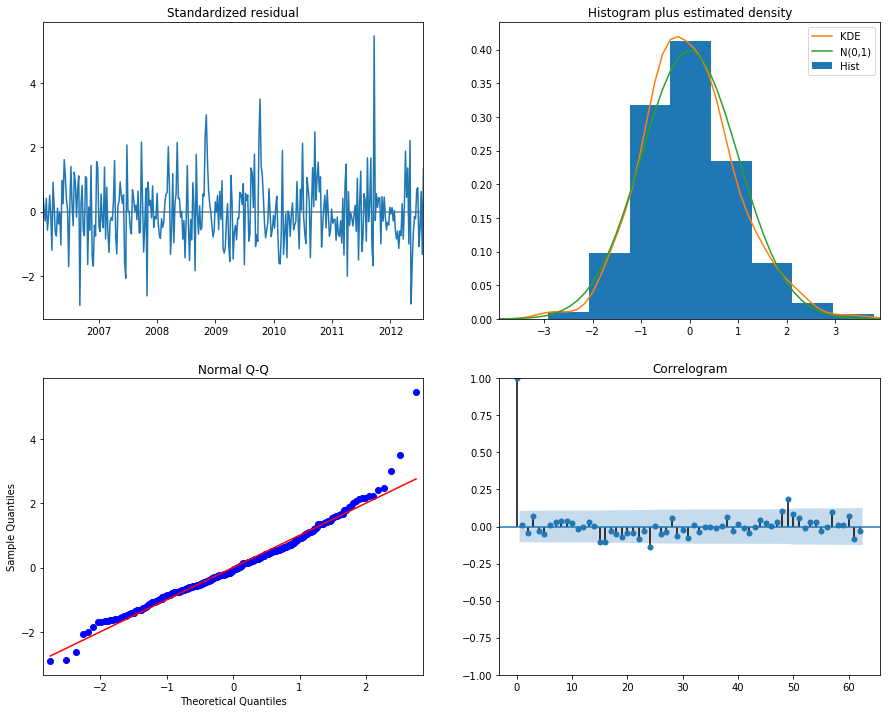

In [27]:
results.plot_diagnostics(figsize=(15, 12), lags = 62)
plt.show()

# 验证预测

## 数据内预测
首先在数据集内进行预测，并且预测输入使用真实输入，而不使用上一步的预测，结果如下所示，单步预测能够较好的体现数据变化的真实情况。

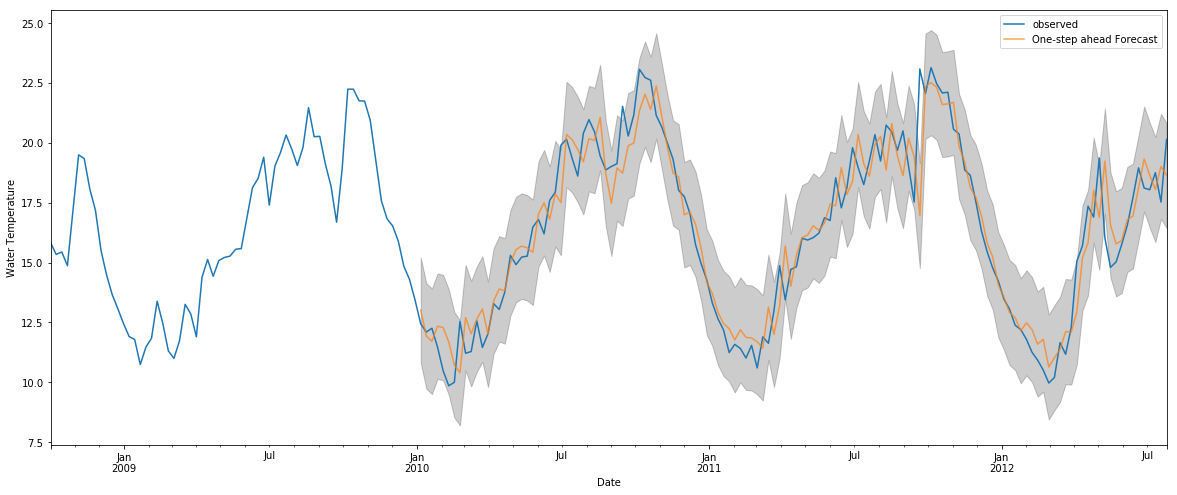

In [70]:
pred = results.get_prediction(start=pd.to_datetime('2010-01-06'), dynamic=False)
pred_ci = pred.conf_int()

ax = data_train[300:].plot(label='observed',figsize = (20,8))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
 
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
 
ax.set_xlabel('Date')
ax.set_ylabel('Water Temperature')
plt.legend()
plt.show()

### 量化预测的准确性
使用均方误差$MSE=\frac{1}{m}\sum^m_{i=1}(y_i-\hat y_i)$，结果如下所示：

In [73]:
predicted = pred.predicted_mean
truth = data_train['2010-01-06':]
 
# Compute the mean square error
mse = ((predicted - truth) ** 2).mean()
print('单步预测的均方误差为：{}'.format(round(mse, 2)))

单步预测的均方误差为：1.34


## 预测外推
接下来对测试集进行预测，结果如下图所示，同样能够很好地预测数据的变化趋势，甚至在较长一段时间内仍然能够外推正确的变化趋势，但是对于数据峰值的拟合程度不够好。

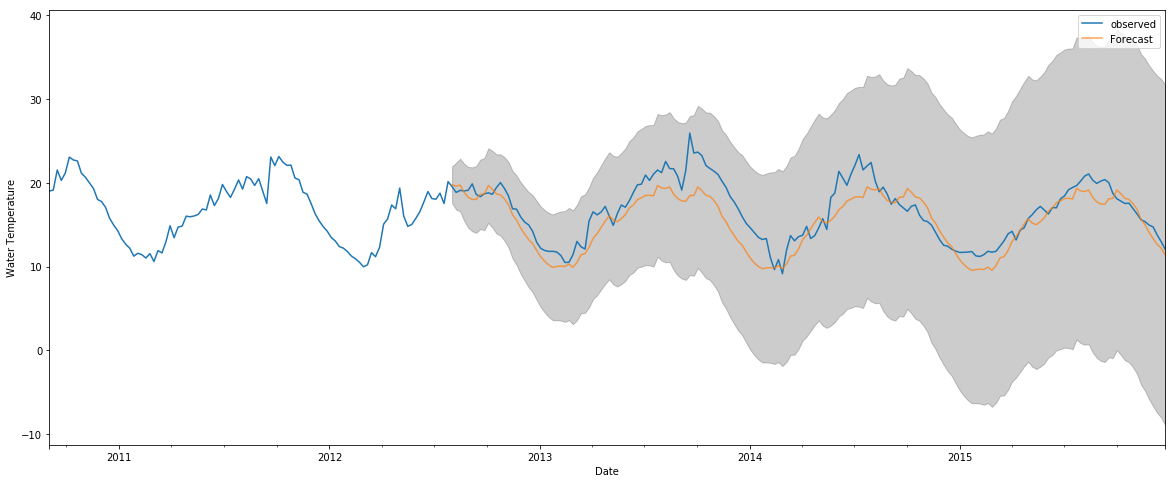

In [67]:
fore = results.get_forecast(178)
fore_ci = fore.conf_int()

ax = data_week[400:].plot(label='observed',figsize = (20,8))
fore.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.2)
 
ax.set_xlabel('Date')
ax.set_ylabel('Water Temperature')
plt.legend()
plt.show()

### 量化预测的准确性
使用均方误差$MSE=\frac{1}{m}\sum^m_{i=1}(y_i-\hat y_i)$，结果如下所示：

In [74]:
forecasted = fore.predicted_mean
truth = data_test
 
# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('外推的均方误差为：{}'.format(round(mse, 2)))

外推的均方误差为：4.38


# 结果讨论
上述结果证明了对于气象数据水文数据准确预测的困难性，在网格搜索过程中，可以加宽网格的深度，获得更好的结果。
# 扩展
由于全球变暖温升的存在，可以讨论一下SARIMA模型中的线型趋势，结果如下：

In [78]:
mod = ARIMA(data_week, order=(1, 1, 1), seasonal_order=(1, 1, 2, 52), trend='ct', enforce_stationarity=False, enforce_invertibility=False)

results = mod.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-9.387e-09,3.97e-10,-23.635,0.000,-1.02e-08,-8.61e-09
x1,2.475e-08,3.15e-10,78.676,0.000,2.41e-08,2.54e-08
ar.L1,0.8354,0.030,27.885,0.000,0.777,0.894
ma.L1,-0.9913,0.018,-56.256,0.000,-1.026,-0.957
ar.S.L52,-0.6089,0.087,-6.994,0.000,-0.780,-0.438
ma.S.L52,-0.2554,0.102,-2.507,0.012,-0.455,-0.056
ma.S.L104,-0.4395,0.083,-5.297,0.000,-0.602,-0.277
sigma2,1.0844,0.045,23.933,0.000,0.996,1.173


In [77]:
2.475*52*100*10**(-8)

0.000104884

据统计，气温在过去50年间上升了大约3摄氏度左右，所以香溪河水温100年升高0.0001摄氏度，比气温上升速率小很多。